In [6]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Create device agnostic code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

batch_size = 32
epoch = 40

cpu


Load dataset

In [8]:
dataset = pd.read_csv("./database/dataset.csv")
dataset = dataset.values

dataset = dataset.astype('uint8')

dataset = torch.from_numpy(dataset)

In [9]:
print(dataset.shape)
print("order_id  product_id  order_dow  order_hour_of_day  reordered")
for i in range(0, 10):
  print(dataset[i])

torch.Size([68853, 5])
order_id  product_id  order_dow  order_hour_of_day  reordered
tensor([ 1, 99,  4, 10,  1], dtype=torch.uint8)
tensor([ 1, 21,  4, 10,  2], dtype=torch.uint8)
tensor([ 1, 94,  4, 10,  3], dtype=torch.uint8)
tensor([ 1, 36,  4, 10,  5], dtype=torch.uint8)
tensor([ 2, 57,  5,  9,  6], dtype=torch.uint8)
tensor([ 2, 25,  5,  9,  7], dtype=torch.uint8)
tensor([ 3, 41,  5, 17,  8], dtype=torch.uint8)
tensor([ 3, 34,  5, 17,  9], dtype=torch.uint8)
tensor([ 3, 90,  5, 17, 10], dtype=torch.uint8)
tensor([ 5, 21,  6, 16, 21], dtype=torch.uint8)


Process the data

In [10]:
X = torch.zeros(size=(len(dataset),102,1), dtype=torch.uint8)
y = torch.zeros(len(dataset), dtype=torch.uint8)

def process():
  for i in range(0,len(dataset)):
    j = (int)(dataset[i][1])
    X[i][j][0] = 1
    X[i][100][0] = dataset[i][2]
    X[i][101][0] = dataset[i][3]
    y[i] = dataset[i][4]

process()

In [11]:
print(len(dataset))
print(X.shape)
print(len(X))

68853
torch.Size([68853, 102, 1])
68853


Split the data into training, validation and testing set.

In [12]:
def split_data():
  """
  This is split function.
  Split X into X_train, X_valid, X_test
  Split y into y_train, y_valid, y_test
  The number of X_train : X_valid : X_test is [98 : 1 : 1]
  len(X_train) = 67476
  len(X_valid) = 688
  len(X_test) = 688
  """
  random = np.random.permutation(len(X))    # random is a list that store the random number
  train_size = int(0.98 * len(X))
  valid_size = int(0.01 * len(X))
  test_size = int(0.01 * len(X))

  X_train = torch.zeros(size=(train_size,102,1), dtype=torch.float32)
  X_valid = torch.zeros(size=(valid_size,102,1), dtype=torch.float32)
  X_test = torch.zeros(size=(test_size+2,102,1), dtype=torch.float32)
  y_train = torch.zeros(train_size)
  y_valid = torch.zeros(valid_size)
  y_test = torch.zeros(test_size+2)

  for i in range(0, len(random)):
    index = random[i]
    if(i < train_size):
      X_train[i] = X[index]
      y_train[i] = y[index]
    elif(i >= train_size and i < train_size + valid_size):
      X_valid[i-train_size] = X[index]
      y_valid[i-train_size] = y[index]
    else:
      X_test[i-train_size-valid_size] = X[index]
      y_test[i-train_size-valid_size] = y[index]

  return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = split_data()

y_train = y_train.type(torch.LongTensor)
y_valid = y_valid.type(torch.LongTensor)
y_test = y_test.type(torch.LongTensor)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_valid = X_valid.to(device)
y_valid = y_valid.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [13]:
# X_train = X_train.view(-1,28*28)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(X_train.dtype)
print(X_valid.dtype)
print(X_test.dtype)

torch.Size([67475, 102, 1])
torch.Size([688, 102, 1])
torch.Size([690, 102, 1])
torch.float32
torch.float32
torch.float32


In [14]:
def batch():
  X_train_batch = []
  y_train_batch = []

  batch_num = (int)(np.ceil(len(X_train)/batch_size))
  X_mini_batch = torch.zeros(size=(batch_size,102,1), dtype=torch.float32)
  y_mini_batch = torch.zeros(batch_size, dtype=torch.uint8)

  for i in range(0, len(X_train)):
    if i % batch_size == 0 and i != 0:
      X_train_batch.append(X_mini_batch)
      y_train_batch.append(y_mini_batch)
      if len(X_train_batch) == batch_num - 1:
        X_mini_batch = torch.zeros(size=(len(X_train)-batch_size*len(X_train_batch),102,1), dtype=torch.float32)
        y_mini_batch = torch.zeros(len(X_train)-batch_size*len(X_train_batch), dtype=torch.uint8)
      else:
        X_mini_batch = torch.zeros(size=(batch_size,102,1), dtype=torch.float32)
        y_mini_batch = torch.zeros(batch_size, dtype=torch.uint8)
    elif i == len(X_train)-1:
      X_train_batch.append(X_mini_batch)
      y_train_batch.append(y_mini_batch)
    
    X_mini_batch[i % batch_size] = X_train[i]
    y_mini_batch[i % batch_size] = y_train[i]

  return X_train_batch, y_train_batch

X_train_batch, y_train_batch = batch()

There are 100 Products (100 neurals)

There are 24 hours (1 neural)

There are 7 days (1 nerual)


In [15]:
class ProductRecommendModel(torch.nn.Module):
    def __init__(self):
      super(ProductRecommendModel,self).__init__()
      self.layer1 = torch.nn.Linear(102,102)
      self.layer2 = torch.nn.Linear(102,101)
      self.layer3 = torch.nn.Linear(101,100)
      # self.layer4 = torch.nn.Linear(32,16)
      # self.layer5 = torch.nn.Linear(16,8)
      # self.layer6 = torch.nn.Linear(8,4)
      # self.layer7 = torch.nn.Linear(4,2)

    def forward(self,x):
      x = x.view(-1,102)   # resize [batchsize,1,28,28] -> [batchsize,784] input layer
      x = F.relu(self.layer1(x))
      x = F.relu(self.layer2(x))
      # x = F.relu(self.layer3(x))
      # x = F.relu(self.layer4(x))
      # x = F.relu(self.layer5(x))
      # x = F.relu(self.layer6(x))

      out = self.layer3(x)

      return out


product_recommend_model = ProductRecommendModel().to(device)

In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(product_recommend_model.parameters(),lr=0.01)

train_loss = []     # The list of train loss
valid_loss = []     # The list of validation loss
train_accuracy = []   # The list of train accuracy
valid_accuracy = []   # The list of valid accuracy

In [17]:
def train(epoch):
  total = len(X_train)

  with tqdm(range(0, len(X_train_batch))) as loop:
    for i in loop:
      loop.set_description(f"Epoch {epoch}")
      optimizer.zero_grad()
      outputs = product_recommend_model(X_train_batch[i].to(device))
      loss = criterion(outputs, y_train_batch[i].to(device))
      loss.backward()
      optimizer.step()

  correct = 0
  total = len(X_train)
  loss = 0.0
  with torch.no_grad():
    outputs = product_recommend_model(X_train)
    loss = criterion(outputs, y_train)
    _, predicted = torch.max(outputs.data, dim=1)
    for i in range(0, len(predicted)):
      if(predicted[i] == y_train[i]):
        correct += 1
  train_loss.append(loss.cpu().numpy())
  train_accuracy.append(100*correct/total)


In [18]:
def valid(epoch):
  correct = 0
  total = len(X_valid)
  loss = 0.0
  with torch.no_grad():
    outputs = product_recommend_model(X_valid)
    loss = criterion(outputs, y_valid)
    _, predicted = torch.max(outputs.data, dim=1)
    for i in range(0, len(predicted)):
      if(predicted[i] == y_valid[i]):
        correct += 1
  
  valid_loss.append(loss.cpu().numpy())
  valid_accuracy.append(100*correct/total)


In [19]:
def test():
  correct = 0
  total = len(X_test)
  with torch.no_grad():
    outputs = product_recommend_model(X_test)
    _, predicted = torch.max(outputs.data, dim=1)
    for i in range(0, len(predicted)):
      if(predicted[i] == y_test[i]):
        correct += 1
  print(f'Accuracy on test set: {100*correct/total:.3f}%')

In [20]:
def plot_epoch_diff():
  """
  a) Plot the both training loss and validation loss for each epochs.
  b) Plot the both training accuracy and validation accuracy for each epochs.
  """
  x = [a for a in range(1,epoch+1)]
  plt.figure(figsize=(16, 6))
  plt.subplot(1,2,1)
  plt.plot(x,train_loss, label='training loss')
  plt.plot(x,valid_loss, label='validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Loss Function in 5 Dense Layers Model', fontsize=14, fontweight='bold')
  plt.legend()
  plt.xticks(ticks=x)

  plt.subplot(1,2,2)
  plt.plot(x,train_accuracy, label='training accuracy')
  plt.plot(x,valid_accuracy, label='validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accurate')
  plt.title(f'Accuracy in 5 Dense Layers Model', fontsize=14, fontweight='bold')
  plt.legend()
  plt.xticks(ticks=x)

  plt.show()

Epoch 40: 100%|██████████| 2109/2109 [00:11<00:00, 185.55it/s]


Accuracy on test set: 11.304%


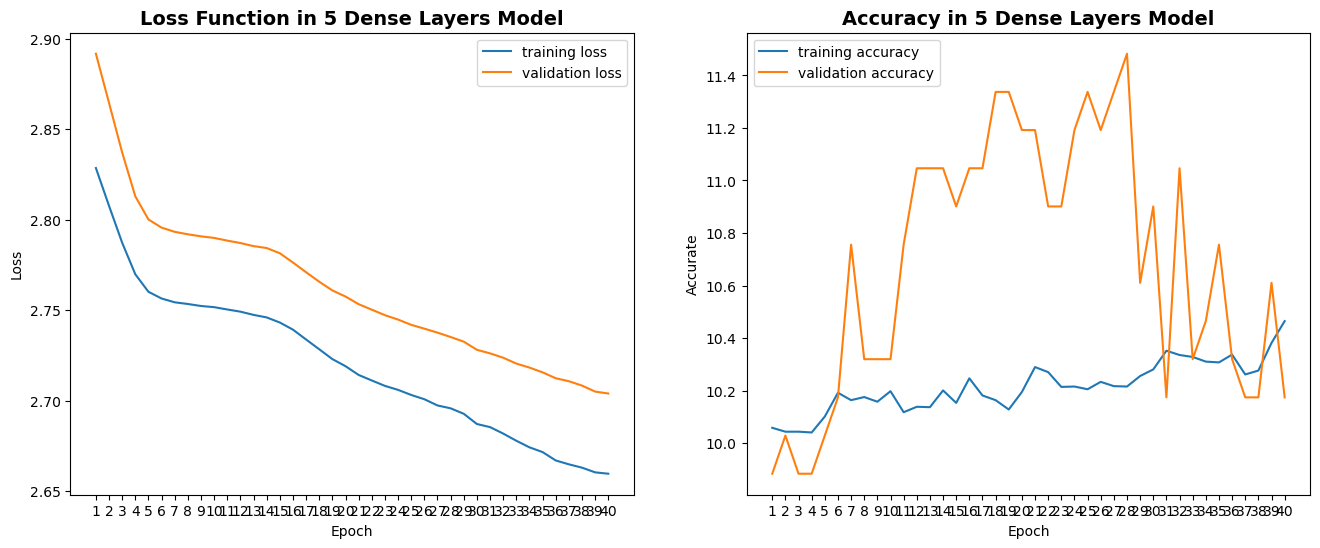

In [21]:
def main():
  for i in range(1, epoch+1):
    train(i)
    valid(i)
  test()
  plot_epoch_diff()

main()